# Fishing Effort
Total fishing effort within 'national waters' by year. Most figures represent activity within exclusive economic zones; figures were also calculated for joint regimes and disputed areas, which are both held separate from single-sovereign waters.

Note that this is a parameterized widget; the specification passed to the API will not be renderable without the geostore identifier being inserted.  

_Author: Peter Kerins_  
_Created: 28 Sep 2021_  
_Environment: jupyterlab_  

## Style
- Vega chart
- Ocean Watch country page - parameterized chart
- Time series
- Line chart

## Data
Underlying dataset: com.030d Fishing Effort by Zone  
~Widget data: [ow_widget_territory](https://resourcewatch.carto.com/u/wri-rw/dataset/ow_widget_territory) (master table for all territory-based widgets on Ocean Watch)~  

## Preparation

In [2]:
import json
from vega import Vega
from IPython.display import display

In [3]:
def Vega(spec):
    bundle = {}
    bundle['application/vnd.vega.v5+json'] = spec
    display(bundle, raw=True)

In [4]:
widget_width = 400
widget_height = 300

# Country Widget
For the moment, we will ignore all areas besides uncontested exclusive economic zones

## Demo Query
`geostore_prod` identifier corresponds to Angola
```sql
SELECT mrgid, geoname, pol_type, gadm.gid_0, year, value FROM (
  SELECT *,
    CASE WHEN iso_ter1 IS NULL THEN iso_sov1 ELSE iso_ter1 END AS gid_0
  FROM com_030d_fishing_effort_by_zone) AS data
LEFT OUTER JOIN gadm36_0 AS gadm ON data.gid_0 = gadm.gid_0
WHERE pol_type = '200NM'
AND year <= 2020
AND gadm.geostore_prod='c0e30c8d35f81d8d19e2c0f5dd7e0798'
ORDER BY data.year ASC
```

## Parameterized Query
```sql
SELECT pol_type, gadm.gid_0, year, SUM(value::NUMERIC) AS value FROM (
  SELECT *,
    CASE WHEN iso_ter1 IS NULL THEN iso_sov1 ELSE iso_ter1 END AS gid_0
  FROM com_030d_fishing_effort_by_zone) AS data
LEFT OUTER JOIN gadm36_0 AS gadm ON data.gid_0 = gadm.gid_0
WHERE pol_type = '200NM'
AND year <= 2020
AND gadm.{{geostore_env}}='{{geostore_id}}'
GROUP BY pol_type, gadm.gid_0, year
ORDER BY data.year ASC
```

## Specification
Vega code presumes RW-style `config` element present

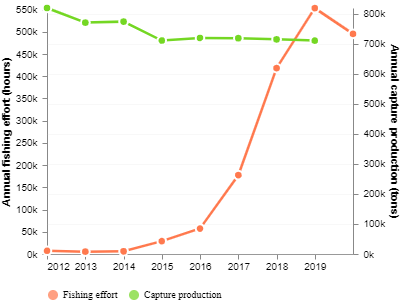

In [5]:
spec=json.loads("""
{
  "schema": "https://vega.github.io/schema/vega/v5.json",
  "description": "Fishing effort per year, by zone",
  "width": 400,
  "height": 250,
  "padding": 0,
  "autosize": {"type": "fit", "contains": "padding"},
  "signals": [{"name": "date_min", "update": "data('effort_table')[0]['year']"}],
  "data": [
    {
      "name": "effort_table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT pol_type, gadm.gid_0, year, SUM(value::NUMERIC) AS effort FROM (SELECT *, CASE WHEN iso_ter1 IS NULL THEN iso_sov1 ELSE iso_ter1 END AS gid_0 FROM com_030d_fishing_effort_by_zone) AS data LEFT OUTER JOIN gadm36_0 AS gadm ON data.gid_0 = gadm.gid_0 WHERE pol_type = '200NM' AND year <= 2020 AND gadm.gid_0='BRA' GROUP BY pol_type, gadm.gid_0, year ORDER BY data.year ASC",
      "format": {
        "type": "json",
        "property": "rows",
        "parse": {"year": "utc:'%Y'"}
      },
      "transform": []
    },
    {
      "name": "capture_table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT gid_0, year, SUM(value) AS capture FROM foo_062_rw0_fishery_production_edit INNER JOIN gadm36_0 gadm on gadm.gid_0 = iso3_code WHERE type = 'Capture_quantity' AND measure = 'Q_tlw' AND gid_0 = 'BRA' GROUP BY gid_0, year ORDER BY year ASC",
      "format": {
        "type": "json",
        "property": "rows",
        "parse": {"year": "utc:'%Y'"}
      },
      "transform": [{"type": "filter", "expr": "datum.year >= date_min"}]
    }
  ],
  "scales": [
    {
      "name": "datescale",
      "type": "time",
      "domain": {
        "fields": [
          {"data": "effort_table", "field": "year"},
          {"data": "capture_table", "field": "year"}
        ]
      },
      "range": "width"
    },
    {
      "name": "yscale_left",
      "type": "linear",
      "domain": {"data": "effort_table", "fields": ["effort"]},
      "range": "height",
      "padding": 0.1
    },
    {
      "name": "yscale_right",
      "type": "linear",
      "domain": {"data": "capture_table", "fields": ["capture"]},
      "range": "height",
      "padding": 0.1
    },
    {
      "name": "colors",
      "type": "ordinal",
      "domain": ["Fishing effort", "Capture production"],
      "range": ["#E9573F", "#8CC152"]
    }
  ],
  "axes": [
    {
      "orient": "bottom",
      "scale": "datescale",
      "domain": true,
      "labelFlush": true,
      "labelOverlap": true,
      "labelBaseline": "middle",
      "ticks": true,
      "grid": false,
      "titleFont": "Lato",
      "labelPadding": 7
    },
    {
      "orient": "left",
      "scale": "yscale_left",
      "domain": true,
      "labelBaseline": "middle",
      "labelAlign": "right",
      "labelPadding": 5,
      "grid": false,
      "gridOpacity": 0.2,
      "format": "s",
      "title": "Annual fishing effort (hours)"
    },
    {
      "orient": "right",
      "scale": "yscale_right",
      "domain": true,
      "labelBaseline": "middle",
      "labelAlign": "left",
      "labelPadding": 5,
      "grid": true,
      "gridOpacity": 0.2,
      "format": "s",
      "title": "Annual capture production (tons)"
    }
  ],
  "marks": [
    {
      "name": "effort",
      "type": "line",
      "from": {"data": "effort_table"},
      "interactive": false,
      "encode": {
        "enter": {
          "x": {"scale": "datescale", "field": "year"},
          "y": {"scale": "yscale_left", "field": "effort"},
          "stroke": {"value": "#E9573F"},
          "strokeWidth": {"value": 2.5},
          "clip": {"value": true},
          "interpolate": {"value": "linear"}
        },
        "update": {"strokeOpacity": {"value": 1}},
        "hover": {"strokeOpacity": {"value": 0.5}}
      }
    },
    {
      "name": "effort_points",
      "type": "symbol",
      "from": {"data": "effort_table"},
      "encode": {
        "enter": {
          "x": {"scale": "datescale", "field": "year"},
          "y": {"scale": "yscale_left", "field": "effort"},
          "size": {"signal": "(width*height)/1000"},
          "stroke": {"value": "white"},
          "strokeOpacity": {"value": 1},
          "fillOpacity": {"value": 1},
          "strokeWidth": {"value": 2},
          "clip": {"value": true},
          "shape": {"value": "circle"}
        },
        "update": {"fill": {"value": "#E9573F"}},
        "hover": {"fill": {"value": "#666666"}}
      }
    },
    {
      "name": "capture",
      "type": "line",
      "from": {"data": "capture_table"},
      "interactive": false,
      "encode": {
        "enter": {
          "x": {"scale": "datescale", "field": "year"},
          "y": {"scale": "yscale_right", "field": "capture"},
          "stroke": {"value": "#8CC152"},
          "strokeWidth": {"value": 2.5},
          "clip": {"value": true},
          "interpolate": {"value": "linear"}
        },
        "update": {"strokeOpacity": {"value": 1}},
        "hover": {"strokeOpacity": {"value": 0.5}}
      }
    },
    {
      "type": "symbol",
      "from": {"data": "capture_table"},
      "encode": {
        "enter": {
          "x": {"scale": "datescale", "field": "year"},
          "y": {"scale": "yscale_right", "field": "capture"},
          "size": {"signal": "(width*height)/1000"},
          "stroke": {"value": "white"},
          "strokeOpacity": {"value": 1},
          "fillOpacity": {"value": 1},
          "strokeWidth": {"value": 2},
          "clip": {"value": true},
          "shape": {"value": "circle"}
        },
        "update": {"fill": {"value": "#8CC152"}},
        "hover": {"fill": {"value": "#666666"}}
      }
    }
  ],
  "legends": [
    {
      "titleFont": "Lato",
      "labelFont": "Lato",
      "fill": "colors",
      "symbolOpacity": 0.7,
      "direction": "horizontal",
      "orient": "bottom"
    }
  ],
  "interaction_config": [
    {
      "name": "tooltip",
      "config": {
        "fields": [
        {
            "column": "year",
            "property": "Year",
            "type": "date",
            "format": "%Y"
          },
          {
            "column": "effort",
            "property": "Fishing effort (hours)",
            "type": "number",
            "format": ",.0f"
          },
          {
            "column": "capture",
            "property": "Capture production (tons)",
            "type": "number",
            "format": ",.0f"
          }
        ]
      }
    }
  ]
}
""")
vega_view=dict(spec)
vega_view['width']=widget_width
vega_view['height']=widget_height
Vega(vega_view)

# Global Widget

## Queries
Includes all zones (with collected data), but not international waters
```sql
SELECT year, SUM(value::NUMERIC) AS total_value 
FROM com_030d_fishing_effort_by_zone AS data
WHERE year <= 2020
GROUP BY year
ORDER BY year ASC
```

## Specification
Vega code presumes RW-style `config` element present

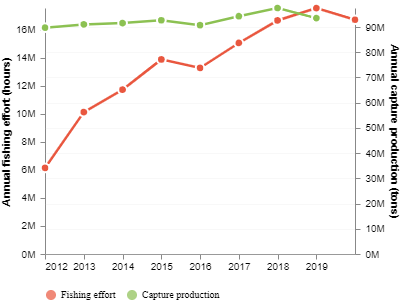

In [6]:
spec=json.loads("""
{
  "schema": "https://vega.github.io/schema/vega/v5.json",
  "description": "Fishing effort per year, by zone",
  "width": 400,
  "height": 250,
  "padding": 0,
  "autosize": {"type": "fit", "contains": "padding"},
  "signals": [{"name": "date_min", "update": "data('effort_table')[0]['year']"}],
  "data": [
    {
      "name": "effort_table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT year, SUM(value::NUMERIC) AS effort FROM com_030d_fishing_effort_by_zone AS data WHERE year <= 2020 GROUP BY year ORDER BY year ASC",
      "format": {
        "type": "json",
        "property": "rows",
        "parse": {
          "year": "utc:'%Y'"
        }
      },
      "transform": []
    },
    {
      "name": "capture_table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q=SELECT year, SUM(value) AS capture FROM foo_062_rw0_fishery_production_edit INNER JOIN gadm36_0 gadm on gadm.gid_0 = iso3_code WHERE type = 'Capture_quantity' AND measure = 'Q_tlw' GROUP BY year ORDER BY year ASC",
      "format": {
        "type": "json",
        "property": "rows",
        "parse": {"year": "utc:'%Y'"}
      },
      "transform": [{"type": "filter", "expr": "datum.year >= date_min"}]
    }
  ],
  "scales": [
    {
      "name": "datescale",
      "type": "time",
      "domain": {
        "fields": [
          {"data": "effort_table", "field": "year"},
          {"data": "capture_table", "field": "year"}
        ]
      },
      "range": "width"
    },
    {
      "name": "yscale_left",
      "type": "linear",
      "domain": {"data": "effort_table", "fields": ["effort"]},
      "range": "height",
      "padding": 0.1
    },
    {
      "name": "yscale_right",
      "type": "linear",
      "domain": {"data": "capture_table", "fields": ["capture"]},
      "range": "height",
      "padding": 0.1
    },
    {
      "name": "colors",
      "type": "ordinal",
      "domain": ["Fishing effort", "Capture production"],
      "range": ["#E9573F", "#8CC152"]
    }
  ],
  "axes": [
    {
      "orient": "bottom",
      "scale": "datescale",
      "domain": true,
      "labelFlush": true,
      "labelOverlap": true,
      "labelBaseline": "middle",
      "ticks": true,
      "grid": false,
      "titleFont": "Lato",
      "labelPadding": 7
    },
    {
      "orient": "left",
      "scale": "yscale_left",
      "domain": true,
      "labelBaseline": "middle",
      "labelAlign": "right",
      "labelPadding": 5,
      "grid": false,
      "gridOpacity": 0.2,
      "format": "s",
      "title": "Annual fishing effort (hours)"
    },
    {
      "orient": "right",
      "scale": "yscale_right",
      "domain": true,
      "labelBaseline": "middle",
      "labelAlign": "left",
      "labelPadding": 5,
      "grid": true,
      "gridOpacity": 0.2,
      "format": "s",
      "title": "Annual capture production (tons)"
    }
  ],
  "marks": [
    {
      "name": "effort",
      "type": "line",
      "from": {"data": "effort_table"},
      "interactive": false,
      "encode": {
        "enter": {
          "x": {"scale": "datescale", "field": "year"},
          "y": {"scale": "yscale_left", "field": "effort"},
          "stroke": {"value": "#E9573F"},
          "strokeWidth": {"value": 2.5},
          "clip": {"value": true},
          "interpolate": {"value": "linear"}
        },
        "update": {"strokeOpacity": {"value": 1}},
        "hover": {"strokeOpacity": {"value": 0.5}}
      }
    },
    {
      "name": "effort_points",
      "type": "symbol",
      "from": {"data": "effort_table"},
      "encode": {
        "enter": {
          "x": {"scale": "datescale", "field": "year"},
          "y": {"scale": "yscale_left", "field": "effort"},
          "size": {"signal": "(width*height)/1000"},
          "stroke": {"value": "white"},
          "strokeOpacity": {"value": 1},
          "fillOpacity": {"value": 1},
          "strokeWidth": {"value": 2},
          "clip": {"value": true},
          "shape": {"value": "circle"}
        },
        "update": {"fill": {"value": "#E9573F"}},
        "hover": {"fill": {"value": "#666666"}}
      }
    },
    {
      "name": "capture",
      "type": "line",
      "from": {"data": "capture_table"},
      "interactive": false,
      "encode": {
        "enter": {
          "x": {"scale": "datescale", "field": "year"},
          "y": {"scale": "yscale_right", "field": "capture"},
          "stroke": {"value": "#8CC152"},
          "strokeWidth": {"value": 2.5},
          "clip": {"value": true},
          "interpolate": {"value": "linear"}
        },
        "update": {"strokeOpacity": {"value": 1}},
        "hover": {"strokeOpacity": {"value": 0.5}}
      }
    },
    {
      "type": "symbol",
      "from": {"data": "capture_table"},
      "encode": {
        "enter": {
          "x": {"scale": "datescale", "field": "year"},
          "y": {"scale": "yscale_right", "field": "capture"},
          "size": {"signal": "(width*height)/1000"},
          "stroke": {"value": "white"},
          "strokeOpacity": {"value": 1},
          "fillOpacity": {"value": 1},
          "strokeWidth": {"value": 2},
          "clip": {"value": true},
          "shape": {"value": "circle"}
        },
        "update": {"fill": {"value": "#8CC152"}},
        "hover": {"fill": {"value": "#666666"}}
      }
    }
  ],
  "legends": [
    {
      "titleFont": "Lato",
      "labelFont": "Lato",
      "fill": "colors",
      "symbolOpacity": 0.7,
      "direction": "horizontal",
      "orient": "bottom"
    }
  ],
  "interaction_config": [
    {
      "name": "tooltip",
      "config": {
        "fields": [
        {
            "column": "year",
            "property": "Year",
            "type": "date",
            "format": "%Y"
          },
          {
            "column": "effort",
            "property": "Fishing effort (hours)",
            "type": "number",
            "format": ",.0f"
          },
          {
            "column": "capture",
            "property": "Capture production (tons)",
            "type": "number",
            "format": ",.0f"
          }
        ]
      }
    }
  ]
}
""")
vega_view=dict(spec)
vega_view['width']=widget_width
vega_view['height']=widget_height
Vega(vega_view)

# RW API

Parameterized widgets created via [widget scripts](https://github.com/resource-watch/data-team-tools/tree/master/advanced_widget_writer).  

[com.030d.rw0 Fishing Effort by Zone](https://resourcewatch.org/data/explore/49b76e0f-3aad-4138-b272-87a10748f2df) ([Admin](https://resourcewatch.org/admin/data/datasets/49b76e0f-3aad-4138-b272-87a10748f2dfedit))  
`49b76e0f-3aad-4138-b272-87a10748f2df`  
[Dataset](https://api.resourcewatch.org/v1/dataset/49b76e0f-3aad-4138-b272-87a10748f2df/), [Widgets](https://api.resourcewatch.org/v1/dataset/49b76e0f-3aad-4138-b272-87a10748f2df/widget)

In [7]:
dataset_id = '49b76e0f-3aad-4138-b272-87a10748f2df'
name = 'Annual Fishing Effort'
description = 'Fishing effort per year, by zone'

- [Country](https://api.resourcewatch.org/v1/widget/6f974b0f-66cf-416b-a5a9-d1012856e4c8?env=production) `6f974b0f-66cf-416b-a5a9-d1012856e4c8`  

dataset_id = '49b76e0f-3aad-4138-b272-87a10748f2df'
name = 'Annual Fishing Effort Excluding International Waters'
description = 'Fishing effort per year, across all nationally administered waters'

- [Global](https://api.resourcewatch.org/v1/widget/c029173d-a568-4f1c-abb5-3835458a91bb?env=production) `c029173d-a568-4f1c-abb5-3835458a91bb`  